# Synthetic Image Generator for YOLOv8

This notebook generates synthetic images for the training, validation and testing. The output of this notebook is required by the **Training+Export.ipynb** notebook.

Authors(s): *Diptabrata Paul, Martin Fränzl*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
from matplotlib import colormaps as cmaps
import os
from tqdm import tqdm
import yaml
from importlib import reload  # Python 3.4+

import image_generator as ig 
pi = np.pi
from multiprocessing import Pool

## Display single image for parameter adjustments

(259, 512, 512)
ok


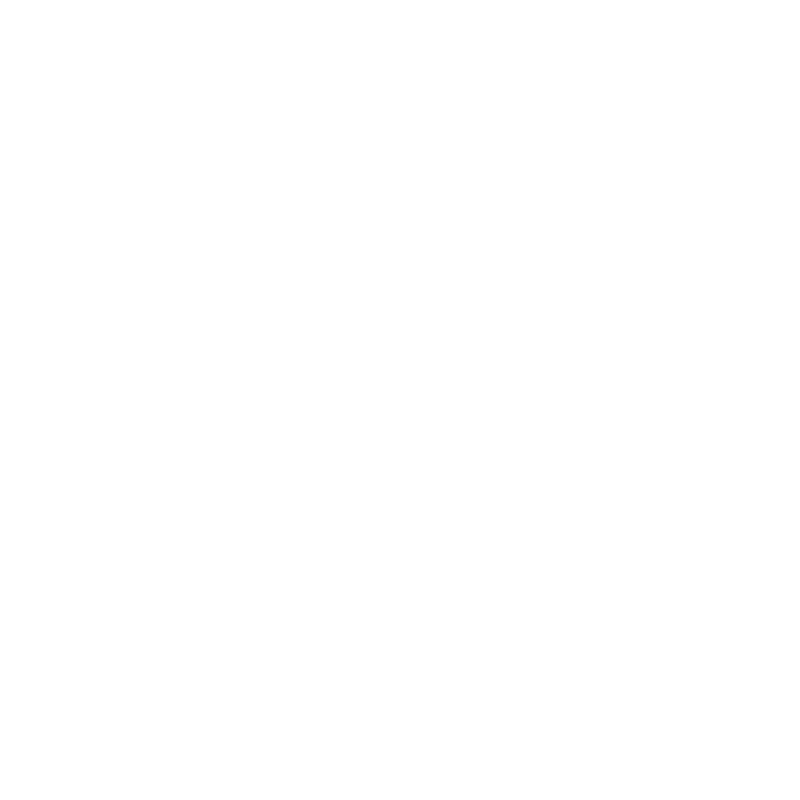

In [13]:
reload(ig)
n_list = [10]                            # Number of points in each class

label_list = ['Ripple']               # Class of points
color_list = ['yellow']             # Color List for each class

# parameters for each class: [[[intensity], [radius], [width]]]
spot_params = [[[0], [4]]]
ring_params = [[[10,20], [100,100], [0,1567]]]

parameter_list = [ring_params]

image_size = 512            # Dimension 
distance = 20               # Min distance between points
offset = 10                 # Boundary padding

objects = ig.getRandom(n_list, image_size, distance, offset, label_list, parameter_list,np.random.default_rng())
plt.close("all")
fig = plt.figure(figsize=(8,8))
print("ok")

In [18]:
%matplotlib widget
snr_range = [50,50]
i_range = [1,1]
reload(ig)

# plt.figure()
bboxes, labels, params, image = ig.generateImage(objects, image_size, snr_range, i_range)
# image = image.clip(-50,50)
print(params)
plt.clf()
plt.imshow(image, cmap=cmaps["Grays"],vmax=1,vmin=0)
plt.colorbar()
ax = fig.gca()
for bbox, label in zip(bboxes, labels):
    x, y = bbox[0]
    x1, y1 = bbox[1]
    ax.add_patch(patches.Rectangle((x,y), x1-x, y1-y, linewidth=1, edgecolor="blue", facecolor='none'))
    ax.annotate(label, (x,y))

(259, 512, 512)
[755, 875, 1491, 1004, 819, 38, 718, 266, 735, 1336]


## Generate images for training, validation and testing

In [21]:
subdir = 'Dataset/'
nimages = [25000, 5000, 1000]
folders = ['train', 'val', 'test']


if not os.path.exists(subdir):
    os.mkdir(subdir)
for i, prefix in enumerate(folders):
    l_dir = subdir  + 'labels'
    i_dir = subdir + 'images'
    if not os.path.exists(i_dir):
        os.mkdir(i_dir)
    elif not os.path.exists(l_dir):
        os.mkdir(l_dir)
        label_dir = l_dir + '/' + prefix + '/'
        os.mkdir(label_dir)
    else:
        image_dir = i_dir + '/' + prefix + '/'
        if not os.path.exists(image_dir):
            os.mkdir(image_dir)
        label_dir = l_dir + '/' + prefix + '/'
        if not os.path.exists(label_dir):
            os.mkdir(label_dir)

    # print(f"generating {prefix} data... ",end=" ", flush=True)
    rngs = []
    def init():
        global rng
        rng = np.random.default_rng()
        os.sleep(rng.uniform(0,2))
    def call(j):
        objects = ig.getRandom(n_list, image_size, distance, offset, label_list, parameter_list,rng)
        bboxes, labels, z_arr ,image = ig.generateImage(objects, image_size, snr_range, i_range,rng) 
        fname = image_dir + 'image_{:05d}.jpg'.format(j,2)
        plt.imsave(fname, image, cmap='gray',vmin=0,vmax=1)
        annotations =[]
        for bbox, label,z in zip(bboxes, labels,z_arr):
            x_center = ((bbox[0][0] + bbox[1][0]) / 2) / image_size
            y_center = ((bbox[0][1] + bbox[1][1]) / 2) / image_size
            width = (bbox[1][0] - bbox[0][0]) / image_size
            height = (bbox[1][1] - bbox[0][1]) / image_size
            z/=1567
            class_id = np.where(np.array(label_list) == label)[0][0]
            annotation = f"{class_id} {x_center} {y_center} {width} {height} {z}"
            annotations.append(annotation)
        labelname = label_dir + 'image_{:05d}.txt'.format(j,2)    
        np.savetxt(labelname, annotations, fmt='%s')
    with Pool(initializer=init) as pool:
        for _ in tqdm(pool.imap_unordered(call,range(nimages[i])),total=nimages[i]):
            pass
        # print(annotations)
    
        
# ig.exportConfig(subdir + 'info.txt', nimages, label_list, parameters_list, n_list, snr_range, i_range, distance, offset)

100%|██████████| 1000/1000 [01:06<00:00, 15.13it/s]


### Generate .yaml file:

In [174]:
file_path = 'dataset.yaml'

dict = {}
for i, prefix in enumerate(folders):
    i_dir =  os.getcwd() + '/' + subdir + prefix
    dict[prefix]=str(i_dir)

dict['nc'] = len(label_list)
dict['names'] = label_list

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)